## create synthe grid

In [1]:
# because Jupyter notebook is not in package
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
from vidmapy.kurucz.atlas import Atlas
from vidmapy.kurucz.synthe import Synthe
from vidmapy.kurucz.parameters import Parameters

In [4]:
atlas_worker= Atlas()
synthe_worker= Synthe()

In [5]:
def get_atlas_model(teff, logg, feh, vmicro=2.):
    p = Parameters(teff=teff, logg=logg, metallicity=feh, microturbulence=vmicro)
    return atlas_worker.get_model(p)

def get_synthe_model(teff, logg, feh, wmin, wmax, resolution, vmicro=2.):
    model = get_atlas_model(teff, logg, feh)
    p_synthe = Parameters(wave_min=wmin, wave_max=wmax, resolution=resolution, metallicity=feh)
    spectrum = synthe_worker.get_spectrum(model, parameters=p_synthe, quiet=False)
    return model, spectrum

[Back to the top](#VidmaPy-examples)

<a id='ex4'></a>
## Parallelization of spectra computation

In [6]:
import multiprocessing as mp
import pickle
import pandas as pd

In [7]:
teff = np.arange(3500, 7250, 250)
logg = np.arange(1., 5.5, 0.5)
feh = np.arange(-1, 0.500001, 0.25)
resolution = 200000.

In [8]:
with open("models.pkl", "rb") as f:
    models = pickle.load(f)

In [9]:
model_params = pd.read_csv("model_params.csv")

In [10]:
def create_grid(wmin, wmax):
    parameters = []
    for i in range(len(model_params)):
        _teff, _logg, _feh = list(model_params[['teff', 'logg', 'feh']].iloc[i])
        p = Parameters(wave_min=wmin, wave_max=wmax, resolution=resolution, metallicity=_feh)
        parameters.append(p) 
    
    workers = [Synthe() for _ in range(len(parameters))]
    
    # Run in parallel
    no_of_processes = 30
    pool = mp.Pool(processes=no_of_processes)
    results = [pool.apply_async(worker.get_spectrum, args=(m, parameter, True))\
                                for m, worker, parameter in zip(models, workers, parameters)]
    results = [r.get() for r in results]
    pool.close()
    pool.join()
    
    return results

In [13]:
wmin, wmax = 5200, 5280
wmin, wmax = 5360, 5440
wmin, wmax = 5530, 5610
wmin, wmax = 6100, 6190
wmin, wmax = 6210, 6260

In [28]:
wmin, wmax = 15575

In [29]:
wmin -= 5
wmax += 5
%time results = create_grid(wmin, wmax)

CPU times: user 3.13 s, sys: 1.47 s, total: 4.6 s
Wall time: 4min 16s


In [30]:
with open("synthe_%d-%d.pkl"%(wmin, wmax), "wb") as f:
    pickle.dump(results, f)

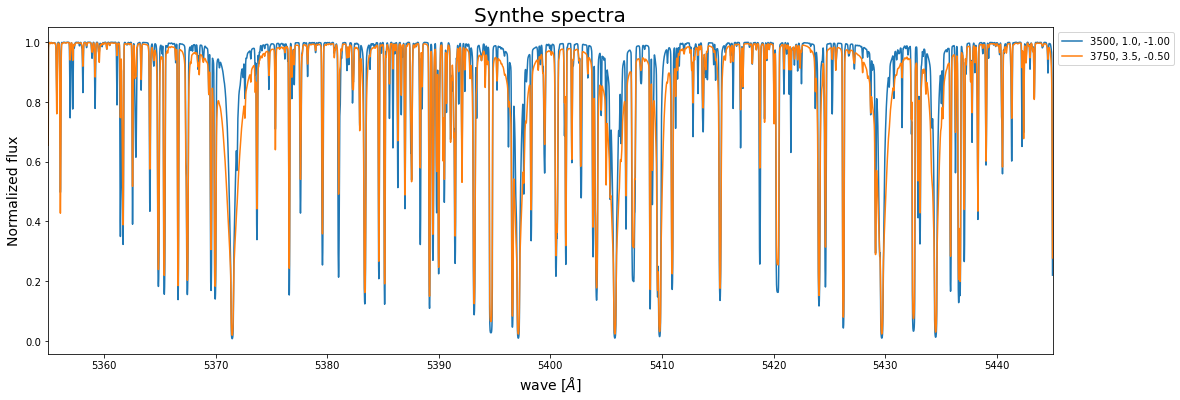

In [31]:
plt.figure(figsize=(18,6))
plt.title("Synthe spectra",fontsize=20)
plt.xlim(wmin, wmax)

for spectrum, (_t, _g, _f) in zip(results[::100][:2], np.array(model_params[['teff', 'logg', 'feh']])[::100][:2]):
    plt.plot(spectrum.wave, spectrum.normed_flux, label='%d, %.1f, %.2f'%(_t, _g, _f))
    #plt.plot(spectrum.wave, spectrum.flux, label='%d, %.1f, %.2f'%(_t, _g, _f))

plt.xlabel(r"wave [$\AA$]", fontsize=14)
plt.ylabel("Normalized flux", fontsize=14)
plt.legend(loc='best', bbox_to_anchor=(1,1))
plt.show()

In [32]:
with open("synthe_5355-5445.pkl", "rb") as f:
    r2 = pickle.load(f)

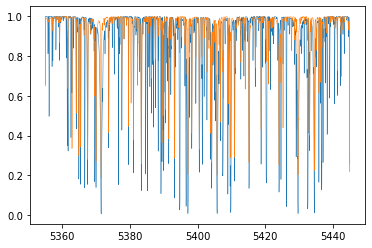

In [33]:
#plt.plot(results[0].wave, results[0].normed_flux)
plt.plot(r2[0].wave, r2[0].normed_flux, lw=0.5)
plt.plot(r2[-1].wave, r2[-1].normed_flux, lw=0.5)